# Association Rule Mining (ARM) and Networking

## Introduction
The data set that will be used for ARM is the Wikipedia data. This data set contains sentences from various Wikipedia pages related to the search terms "Women's Rights" and "Men's Rights." Unlike the Wikipedia data used in the SVM section, the Wikipedia data for this section will be composed of observations being individual sentences (instead of multiple sentences as was in the SVM section). For the specific code that achieved these data sets, please refer to the data cleaning section. For further detail about these data sets, please refer to the exploring data section.

## Theory
Association Rule Mining (ARM) is an unsupervised machine learning algorithm that attempts to discover statistically significant relations between variables in a data set. As the name suggests, ARM is a rule-based algorithm that forms a set of if-then rules to predict the occurrence of an item based on occurrences of other items.

We have a couple of metrics that can be changed to find a decent ARM rule set. First, Support gauges the importance of an item set, where 1 is very important and 0 is irrelevant. Second, Confidence gauges the strength (or statistical significance) of a rule, where 1 is a strong rule and 0 is a rule that never occurs. Third, Lift gauges the association between item sets, where 1 is no association, < 1 represents unlikely association, and > 1 represents likely association. Lastly, Support x Confidence (which is the product of Support and Confidence) is another useful metric to ensure that a rule has a Support and Confidence; this would suggest that a rule occurs frequently and is "strong." Ideally, we want our Support close to 1, Confidence close to 1, and Lift > 1.

## Methods

### Imports

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from apyori import apriori
import networkx as nx 

import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

### Load Data

In [14]:
df=pd.read_csv('./data/00-raw-data/wiki-crawl-results-arm.csv')

corpus = df['text'].to_list()

text = '. '.join(corpus) # convert sentences into one long string

### Filter Data

Since we only want meaningful words to be in our ARM graph, we filter out some words that aren't relevant and aren't covered by nltk's stopwords.

In [15]:
#INITIALIZE
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

stopwords = stopwords.words('english')
add=['000', 'doi' '19', '10', '1960s', '1970s', '1975', '1979', '978', 'isbn', '19th', '20th', 'would', 'also', 'access', 'year', 'without', 'well', 'new', 'york', 'one', 'century', 'since', 'first', 'day', 'time', 'united', 'formed', 'including', 'many', 'states', 'often', 'passed', 'must', 'part', 'made', 'based', 'week', 'organiation', 'form', 'state', 'american', 'world', 'nation', 'country', 'international']
for sp in add: 
    stopwords.append(sp)

    tmp = ''
printable = set(string.printable)
for char in text:
    if char in printable:
        tmp = tmp + char
text = tmp

### Tokenize and Lemmatize

We tokenize the sentences and lemmatize the words into a suitable format for the model.

In [16]:
#BREAK INTO CHUNKS (SENTENCES OR OTHERWISE)
sentences=nltk.tokenize.sent_tokenize(text)  #SENTENCES

print("NUMBER OF SENTENCES FOUND:",len(sentences)); #print(sentences)

#CLEAN AND LEMMATIZE
keep='0123456789abcdefghijklmnopqrstuvwxy';

new_sentences=[]; vocabulary=[]
for sentence in sentences:
    new_sentence=''

    # REBUILD LEMMATIZED SENTENCE
    for word in sentence.split():
        
        #ONLY KEEP CHAR IN "keep"
        tmp2=''
        for char in word: 
            if(char in keep): 
                tmp2=tmp2+char
            else:
                tmp2=tmp2+' '
        word=tmp2

        #-----------------------
        # INSERT CODE TO LEMMATIZE THE WORDS
        #-----------------------
        new_word = lemmatizer.lemmatize(word)

        #REMOVE WHITE SPACES
        new_word=new_word.replace(' ', '')

        #BUILD NEW SENTENCE BACK UP
        if( new_word not in stopwords):
            if(new_sentence==''):
                new_sentence=new_word
            else:
                new_sentence=new_sentence+','+new_word
            if(new_word not in vocabulary): vocabulary.append(new_word)

    #SAVE (LIST OF LISTS)		
    new_sentences.append(new_sentence.split(","))
print("VOCAB LENGTH:",len(vocabulary))

NUMBER OF SENTENCES FOUND: 6156
VOCAB LENGTH: 12378


### Helper Functions

In [17]:
# RE-FORMAT THE APRIORI OUTPUT INTO A PANDAS DATA-FRAME WITH COLUMNS "rhs","lhs","supp","conf","supp x conf","lift"
def reformat_results(results):

    #CLEAN-UP RESULTS 
    keep=[]
    for i in range(0,len(results)):
        # print("=====================================")
        # print(results[i])
        # print(len(list(results[i])))
        for j in range(0,len(list(results[i]))):
            # print(results)
            if(j>1):
                for k in range(0,len(list(results[i][j]))):
                    if(len(results[i][j][k][0])!=0):
                        #print(len(results[i][j][k][0]),results[i][j][k][0])
                        rhs=list(results[i][j][k][0])
                        lhs=list(results[i][j][k][1])
                        conf=float(results[i][j][k][2])
                        lift=float(results[i][j][k][3])
                        keep.append([rhs,lhs,supp,conf,supp*conf,lift])
                        # keep.append()
            if(j==1):
                supp=results[i][j]

    return pd.DataFrame(keep, columns =["rhs","lhs","supp","conf","supp x conf","lift"])

# CONVERT DF TO GRAPH ITEMS
def convert_to_network(df):
    #print(df)

    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="_".join(row[1][0])
        rhs="_".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G

# PLOT GRAPH
def plot_network(G):
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.random_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*10) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    edgecolors="black",
    edge_color=colors_e,
    node_size=4000,
    linewidths=2,
    font_size=8,
    font_color="white",
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    ax.set(title='WikiCrawl Word Association Graph')
    plt.show()

### Train ARM Models and Plot Directed Graphs

While there isn't a specific way of finding the optimal hyperparameter values, we can try varying support and confidence levels and decide based on the directed graph. We train multiple ARM models with increasing levels of support and confidence. We then plot a directed graph for each model.

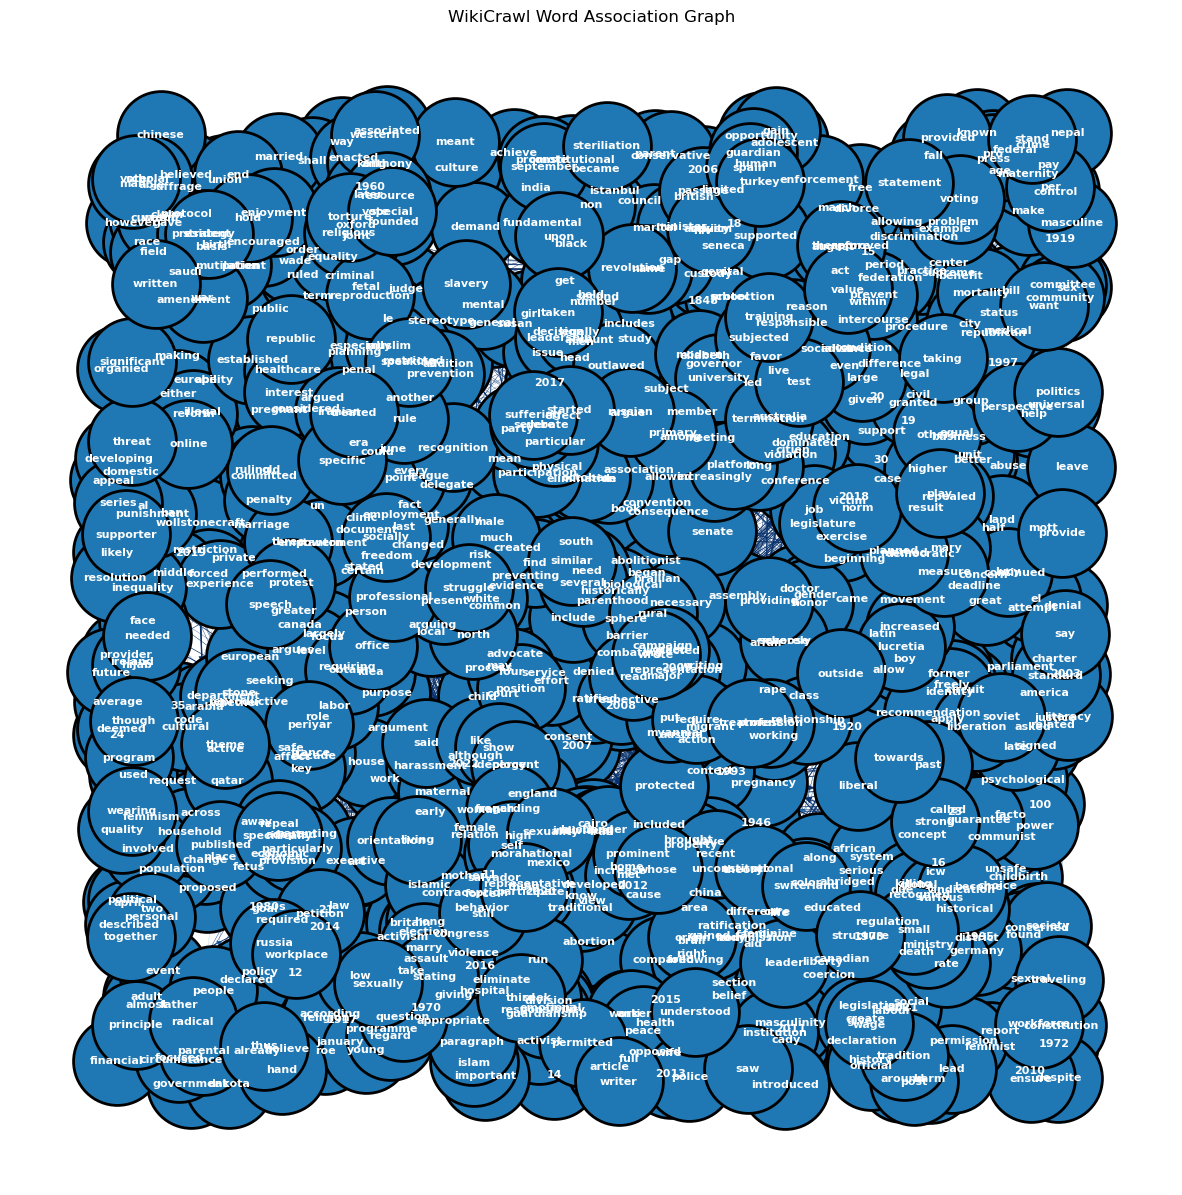

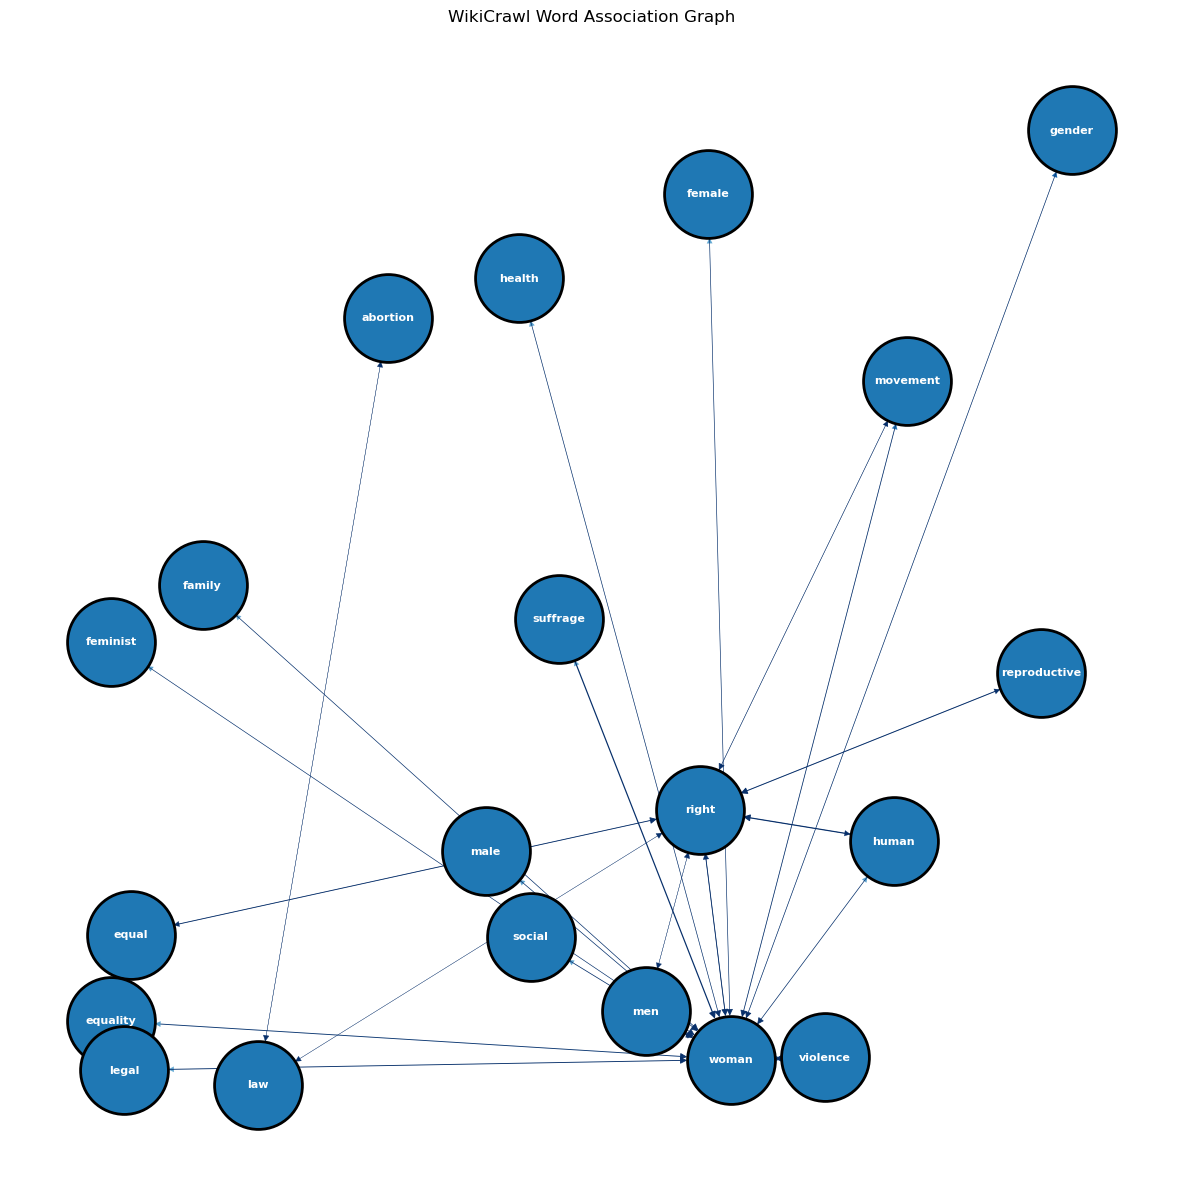

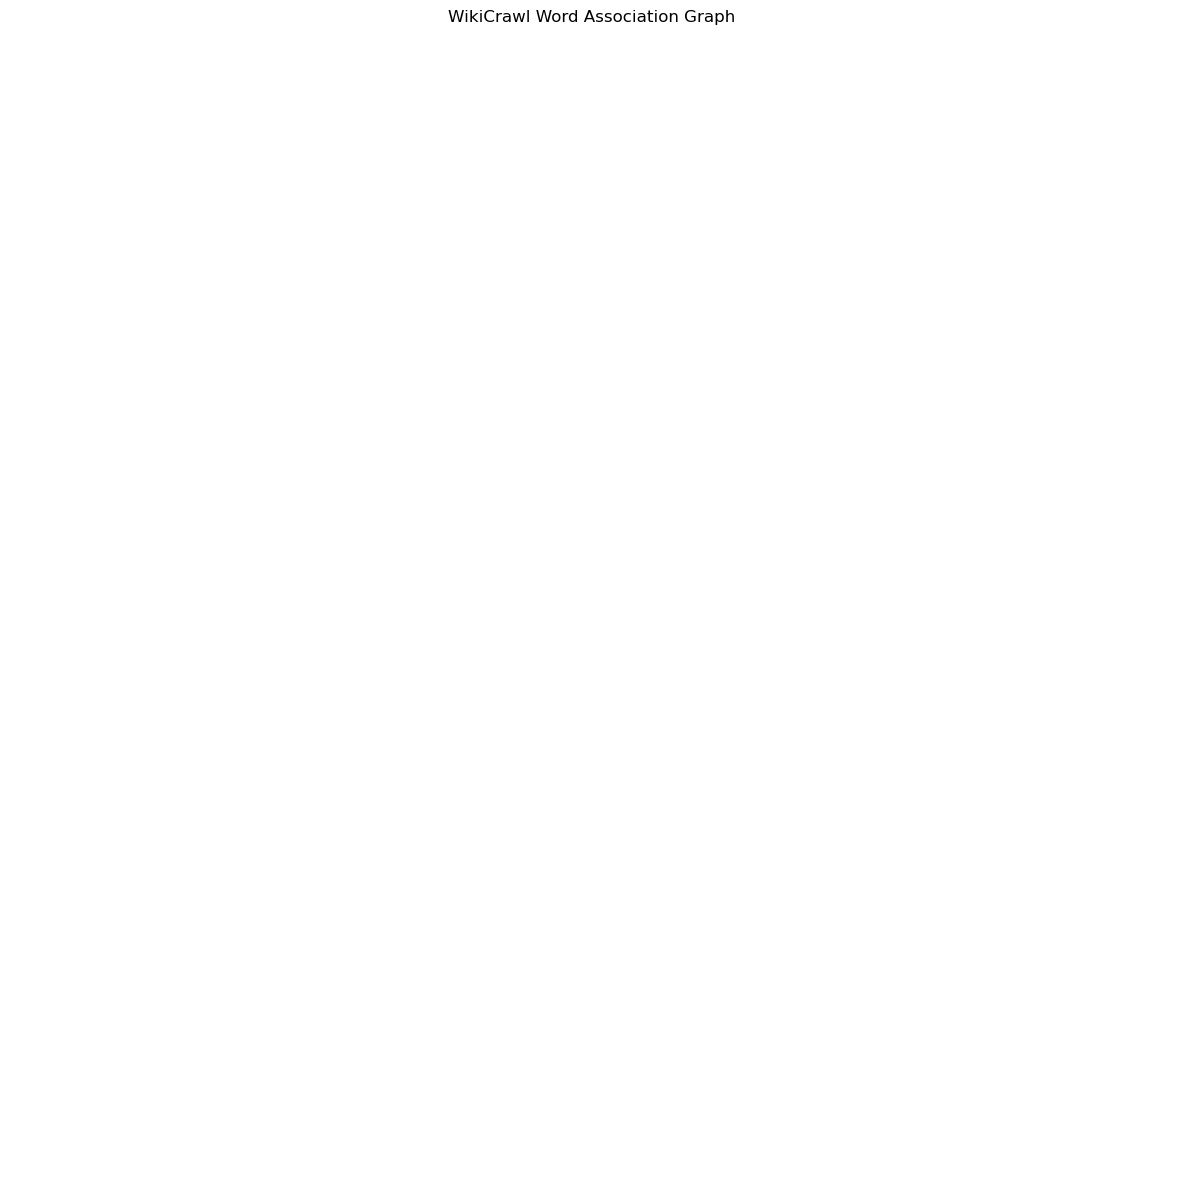

In [18]:
#print("Transactions:",pd.DataFrame(new_sentences))

supp_confs = [[0.002, 0.002],[0.02,0.02],[0.2,0.2]]

for s, c in supp_confs:
    results = list(apriori(new_sentences, min_support=s, min_lift = 1, min_confidence=c, min_length=1, max_length=2))
    pd_results=reformat_results(results)
    G=convert_to_network(pd_results)
    plot_network(G)

### Results

As we can see, when the support and confidence values are smaller, the association rules created are more lenient, resulting in a directed graph that is far too populated to extract anything meaningful. As the support and confidence increases, the word association graph becomes more and more sparse, keeping only words that meet the minimum support and confidence threshholds, making word associations more decipherable, until the threshholds become too strict and no word association rules can be made.

## Conclusion

Interestingly, the meaningful word association graph for the Wikipedia searches appear to heavily relate to women's issues. We can see word relations such as equal => right, woman => equality, and woman => violence. Another notable finding is that the word male only appears with woman. Despite searching for an equal number of Wikipedia pages for the keywords "Women's Rights" and "Men's Rights," it appears that significant word associations can only be found for the former keyword, which may suggest that topics relating to Women's Rights are much more interconnected or have more awareness online.